In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import pyro

/home/aqoku/miniconda3/envs/cellij/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")

In [4]:
import muvi
import cellij
from cellij.core.synthetic import DataGenerator
from cellij.core._pyro_models import Generative, HorseshoeGenerative, LassoGenerative
from cellij.core._pyro_guides import Guide, HorseshoeGuide, LassoGuide
# from muvi import DataGenerator
from cellij.core.models import MOFA

In [5]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7f443aadfb50>


In [6]:
# plotting functions
def _lines(ax, positions, ymin, ymax, horizontal=False, **kwargs):
    if horizontal:
        ax.hlines(positions, ymin, ymax, **kwargs)
    else:
        ax.vlines(positions, ymin, ymax, **kwargs)
    return ax


def lined_heatmap(data, figsize=None, hlines=None, vlines=None, **kwargs):
    """Plot heatmap with horizontal or vertical lines."""
    if figsize is None:
        figsize = (20, 2)
    fig, g = plt.subplots(figsize=figsize)
    g = sns.heatmap(data, ax=g, **kwargs)
    if hlines is not None:
        _lines(
            g,
            hlines,
            *sorted(g.get_xlim()),
            horizontal=True,
            lw=1.0,
            linestyles="dashed",
        )
    if vlines is not None:
        _lines(
            g,
            vlines,
            *sorted(g.get_ylim()),
            horizontal=False,
            lw=1.0,
            linestyles="dashed",
        )
    return g

In [7]:
# random seed to use throughout the notebook
seed = 123

# basic parameters
n_samples = 200
n_features = [200, 300, 400, 500]
n_views = len(n_features)
likelihoods = ["Normal" for _ in range(n_views)]

# more specific parameters to the structure of the latent factors
n_fully_shared_factors = 20
n_partially_shared_factors = 0
n_private_factors = 0

# optional: number of covariates to generate
n_covariates = 0

In [8]:
dg = DataGenerator(
    n_samples,
    n_features,
    likelihoods,
    n_fully_shared_factors,
    n_partially_shared_factors,
    n_private_factors,
    n_covariates=n_covariates,
)

rng = dg.generate(seed=seed)

# center data
dg.normalize(with_std=False)

2023-05-10 21:01:36,225 - cellij.core.synthetic - WARNING - Using a uniform distribution with parameters 0.05 and 0.15 for generating the number of active factor loadings.


In [9]:
feature_offsets = [0] + np.cumsum(n_features).tolist()
vlines = feature_offsets[1:-1]

<Axes: >

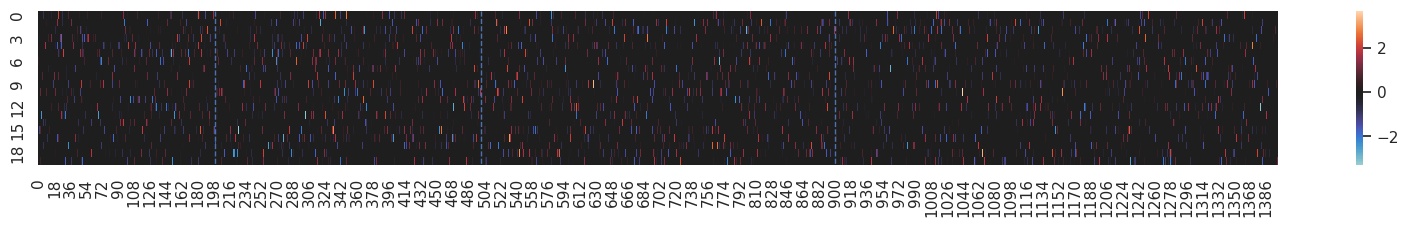

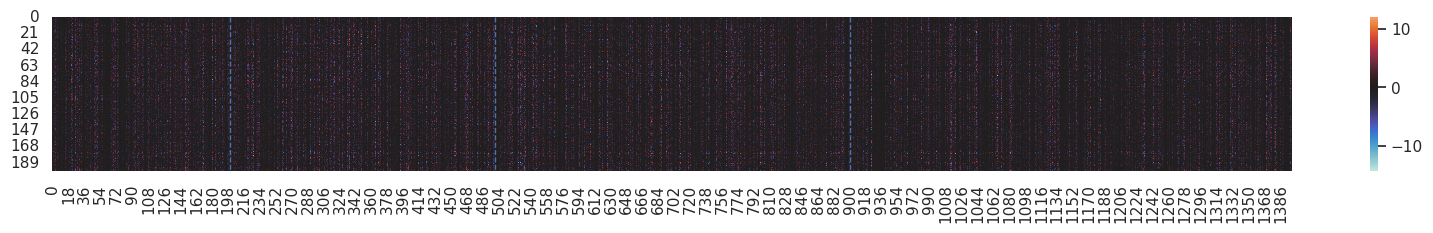

In [10]:
# factor loadings should be fairly sparse
lined_heatmap(dg.w, vlines=vlines, center=0)
lined_heatmap(dg.y, vlines=vlines, center=0)

In [11]:
mdata = dg.to_mdata()
mdata

MuData object with n_obs × n_vars = 200 × 1400
  obsm:	'z'
  4 modalities
    feature_group_0:	200 x 200
      varm:	'w', 'w_mask'
    feature_group_1:	200 x 300
      varm:	'w', 'w_mask'
    feature_group_2:	200 x 400
      varm:	'w', 'w_mask'
    feature_group_3:	200 x 500
      varm:	'w', 'w_mask'

In [15]:
model = MOFA(n_factors=dg.n_factors, sparsity_prior="SpikeNSlab", model_relaxed_bernoulli=False)
model.add_data(data=mdata, na_strategy=None)
# model._model.relaxed_bernoulli

In [16]:
model.fit(likelihoods=mdata.uns['likelihoods'],  epochs=10000, num_particles=20, learning_rate=0.01, optimizer='Clipped', verbose_epochs=500, min_delta=0.01)

2023-05-10 21:02:36,661 - root - INFO - Guessed max_plate_nesting = 4
Epoch      0:        3381.46 	
Epoch    500:          68.87 	|  97.96%	|  33.51s
Epoch   1000:        -546.24 	| 893.19%	|  32.08s
Epoch   1500:        -956.31 	| -75.07%	|  32.20s
Epoch   2000:       -1262.14 	| -31.98%	|  35.61s
Epoch   2500:       -1500.49 	| -18.88%	|  34.82s
Epoch   3000:       -1700.76 	| -13.35%	|  37.63s
Epoch   3500:       -1871.26 	| -10.02%	|  32.05s
Epoch   4000:       -2027.29 	|  -8.34%	|  32.04s
Epoch   4500:       -2158.51 	|  -6.47%	|  31.94s
Epoch   5000:       -2275.91 	|  -5.44%	|  38.56s
Epoch   5500:       -2375.80 	|  -4.39%	|  34.93s
Epoch   6000:       -2471.56 	|  -4.03%	|  32.04s
Epoch   6500:       -2335.97 	|   5.49%	|  32.00s
Epoch   7000:       -2625.44 	| -12.39%	|  32.04s
Epoch   7500:       -2687.25 	|  -2.35%	|  32.78s
Epoch   8000:       -2743.05 	|  -2.08%	|  35.75s
Epoch   8500:       -2795.46 	|  -1.91%	|  32.01s
Epoch   9000:       -2840.91 	|  -1.63%	|  31.90s

[3381.459375,
 3362.7859375,
 3344.4859375,
 3327.74375,
 3307.005859375,
 3289.637109375,
 3269.5154296875,
 3250.5947265625,
 3227.805078125,
 3206.6060546875,
 3185.933984375,
 3160.7861328125,
 3138.7712890625,
 3112.711328125,
 3090.710546875,
 3065.9529296875,
 3039.590234375,
 3012.0416015625,
 2986.816796875,
 2962.210546875,
 2932.7685546875,
 2907.43359375,
 2879.637109375,
 2852.7310546875,
 2827.24765625,
 2800.1267578125,
 2774.2103515625,
 2747.2919921875,
 2720.9755859375,
 2696.8158203125,
 2667.6228515625,
 2644.8716796875,
 2617.634375,
 2594.08984375,
 2568.9298828125,
 2545.704296875,
 2523.99921875,
 2498.1751953125,
 2476.837890625,
 2453.367578125,
 2431.699609375,
 2409.234375,
 2387.5896484375,
 2367.1298828125,
 2347.3369140625,
 2327.7595703125,
 2307.5521484375,
 2288.5318359375,
 2270.132421875,
 2251.501953125,
 2233.490625,
 2215.54609375,
 2198.474609375,
 2181.6544921875,
 2165.6771484375,
 2148.337109375,
 2132.0513671875,
 2115.853125,
 2101.309179687

In [17]:
# model._guide.mode('z').shape

In [18]:
# z_hat = model._guide.median()['z']
# w_hat = model._guide.median()['unscaled_w'] * model._guide.median()['w_scale']

# z_hat = pyro.get_param_store().get_param('FactorModel._guide.locs.z')
# w_hat = pyro.get_param_store().get_param('FactorModel._guide.locs.w')
# sigma_hat = pyro.get_param_store().get_param('FactorModel._guide.locs.sigma')

z_hat = model._guide.median()['z']
# w_hat = model._guide.median()['w']
w_hat = torch.cat([model._guide.median()[f'w_view_{m}'].squeeze() for m in range(n_views)], dim=1)
# z_hat = model._guide.mode('z')
# w_hat = torch.cat([model._guide.mode(f'w_view_{m}').squeeze() for m in range(n_views)], dim=1)
# sigma_hat = model._guide.median()['sigma']

z_hat = z_hat.detach().cpu().numpy().squeeze()
w_hat = w_hat.detach().cpu().numpy().squeeze()

# z_hat = model.get_factor_scores()
# w_hat = np.concatenate([model.get_factor_loadings()[vn] for vn in model.view_names], axis=1)

x_hat = np.matmul(z_hat, w_hat)

# sigma_hat = sigma_hat.detach().cpu().numpy().squeeze()
print(z_hat.shape, w_hat.shape, x_hat.shape)


(200, 20) (20, 1400) (200, 1400)


<Axes: >

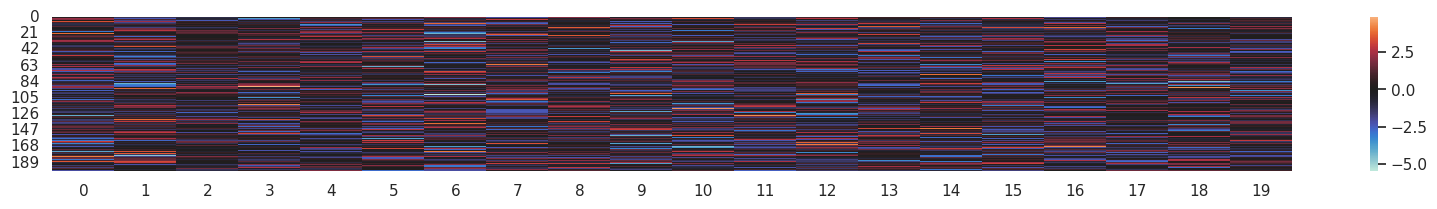

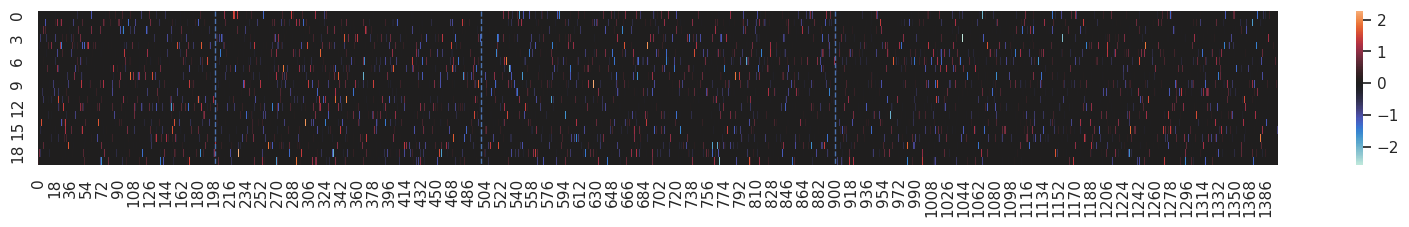

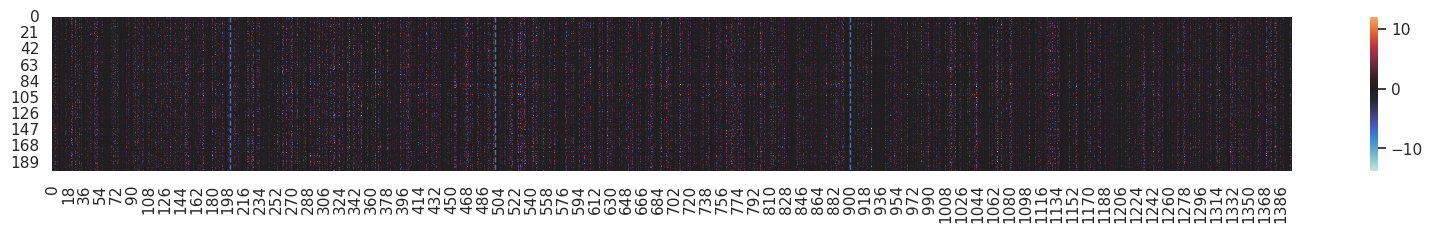

In [19]:

lined_heatmap(z_hat, vlines=vlines, center=0)
lined_heatmap(w_hat, vlines=vlines, center=0)
lined_heatmap(x_hat, vlines=vlines, center=0)
# lined_heatmap(sigma_hat[np.newaxis, :], vlines=vlines, center=0)

<Axes: >

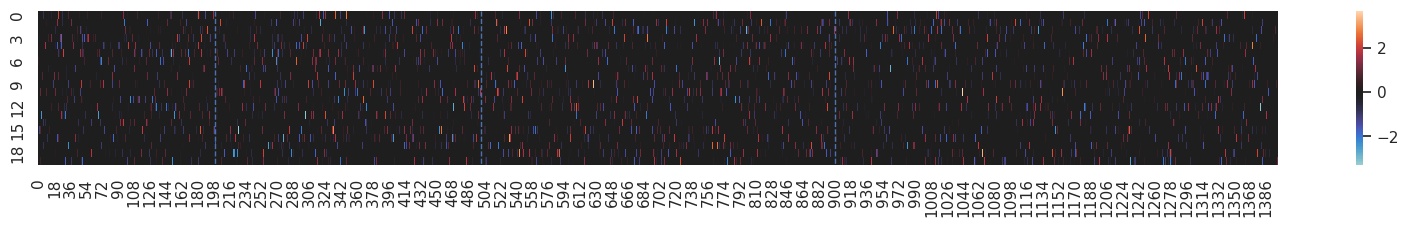

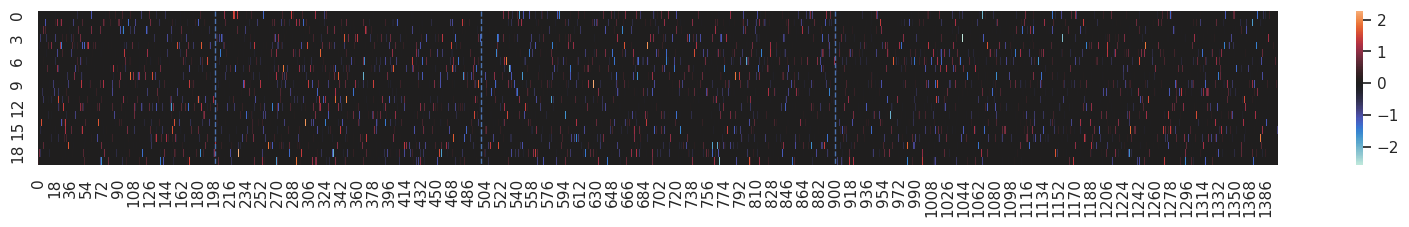

In [20]:

lined_heatmap(dg.w, vlines=vlines, center=0)
lined_heatmap(w_hat, vlines=vlines, center=0)

In [21]:
from scipy.optimize import linear_sum_assignment
from scipy.stats import pearsonr

from sklearn.metrics import pairwise_distances, mean_squared_error, r2_score
from sklearn.metrics import precision_recall_fscore_support, PrecisionRecallDisplay
from sklearn.metrics.pairwise import cosine_similarity

In [22]:
r2_score(dg.y, x_hat)

-0.7115226956928381

In [23]:
def get_opt_thresh(X, Y, thresh_min=0, thresh_max=1, n_thresh=101):
    thresh_max = min(thresh_max, Y.max())
    print(thresh_max)
    thresholds = np.linspace(thresh_min, thresh_max, n_thresh)
    f1s = []
    for threshold in thresholds:
        prec, rec, f1, _ = precision_recall_fscore_support(
            X.flatten(), (Y > threshold).flatten(), average="binary"
        )
        f1s.append(f1)

    return thresholds[np.argmax(f1s)]

In [24]:
opt_order = linear_sum_assignment(-np.abs(pairwise_distances(
    dg.w,
        w_hat,
        metric=lambda a, b: pearsonr(a, b)[0],
        force_all_finite=False,
    )))[-1]
opt_order

array([11,  5,  6,  4,  1, 12, 19, 13, 10,  9,  3,  8, 16, 14,  2, 18,  7,
       17,  0, 15])

In [25]:
# threshold = 0.1
# opt_order = muvi.tl.optim_perm(cosine_similarity(dg.w_mask, np.abs(w_hat) > threshold)).argmax(axis=0)
# opt_order

In [26]:
w_hat = w_hat[opt_order, :]
z_hat = z_hat[:, opt_order]

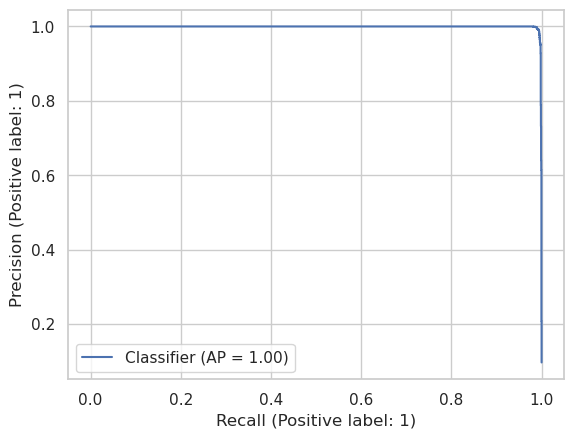

In [27]:
PrecisionRecallDisplay.from_predictions(dg.w_mask.flatten(), np.abs(w_hat).flatten())

In [28]:
threshold = get_opt_thresh(
    dg.w_mask,
    w_hat,
    0,
    5,
)
threshold

2.2775872


/home/aqoku/miniconda3/envs/cellij/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.06832761526107788

<Axes: >

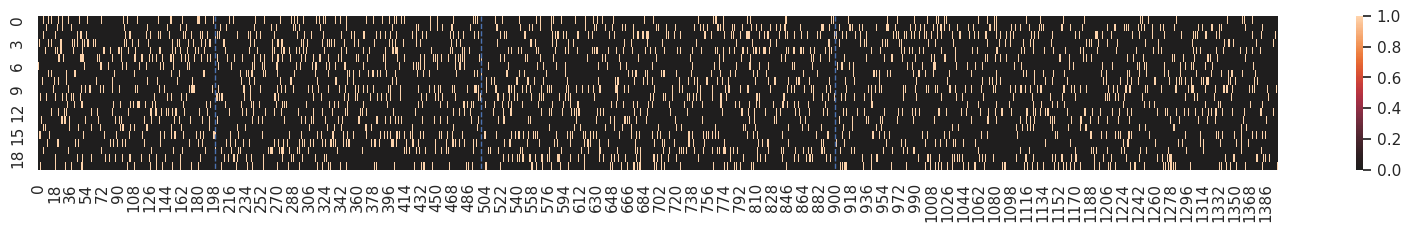

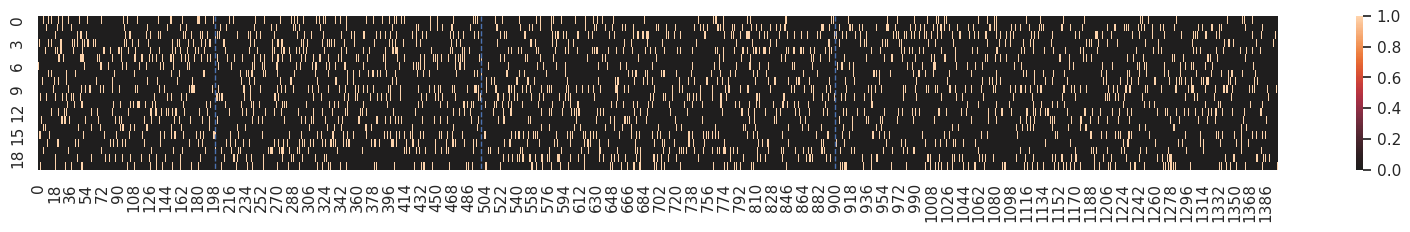

In [29]:
lined_heatmap(dg.w_mask, vlines=vlines, center=0)
lined_heatmap(np.abs(w_hat) > threshold, vlines=vlines, center=0)

In [30]:
precision_recall_fscore_support((dg.w_mask).flatten(), (np.abs(w_hat) > threshold).flatten(), average="binary")

(0.9992467043314501, 0.9836855765665554, 0.991405082212257, None)

In [31]:
pyro.get_param_store().keys()

dict_keys(['FactorModel._guide.locs.z', 'FactorModel._guide.scales.z', 'FactorModel._guide.locs.theta_view_0', 'FactorModel._guide.scales.theta_view_0', 'FactorModel._guide.locs.lambda_view_0', 'FactorModel._guide.scales.lambda_view_0', 'FactorModel._guide.locs.w_view_0', 'FactorModel._guide.scales.w_view_0', 'FactorModel._guide.locs.sigma_view_0', 'FactorModel._guide.scales.sigma_view_0', 'FactorModel._guide.locs.theta_view_1', 'FactorModel._guide.scales.theta_view_1', 'FactorModel._guide.locs.lambda_view_1', 'FactorModel._guide.scales.lambda_view_1', 'FactorModel._guide.locs.w_view_1', 'FactorModel._guide.scales.w_view_1', 'FactorModel._guide.locs.sigma_view_1', 'FactorModel._guide.scales.sigma_view_1', 'FactorModel._guide.locs.theta_view_2', 'FactorModel._guide.scales.theta_view_2', 'FactorModel._guide.locs.lambda_view_2', 'FactorModel._guide.scales.lambda_view_2', 'FactorModel._guide.locs.w_view_2', 'FactorModel._guide.scales.w_view_2', 'FactorModel._guide.locs.sigma_view_2', 'Fact

In [32]:
# model._guide.median()['pscale_0'].shape